# Modelos CNN

passos a decidir

## SAMPLING DE LOS DATOS

1. Weigheted classes para balancear las classes, funciona bien pero va muy lento.
2. 10000 va bien

## DATA AUGMENTATION

## MODELO CNN

1. De momento, con cuatro bloques (ultimo bloque solo una capa convolucional) de convolucionales ha dado mejor resultados.

TODO
PROBAR CON 6 BLOQUES DE CONVOLUCIONALES
DATA AUGMENTATION MAS SIMPLE

## LOSS FUNCTION O OPTIMIZER DEL GRADIENTE

# Database

In [1]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm

import multiprocessing

In [2]:
# Data Augmentation utilities
from torchvision.transforms import functional as F
import random

class AdvancedAugmentation:
    """Custom data augmentation for our drawing dataset"""
    
    def __init__(self, prob=0.5):
        self.prob = prob
    
    def __call__(self, img):
        # Apply transformations with probability
        if random.random() < self.prob:
            # Random rotation (± 20 degrees)
            angle = random.uniform(-20, 20)
            img = F.rotate(img, angle, fill=0)
        
        if random.random() < self.prob:
            # Random shifts (± 15%)
            shift_x = random.uniform(-0.15, 0.15)
            shift_y = random.uniform(-0.15, 0.15)
            img = F.affine(img, angle=0, translate=[shift_x, shift_y], 
                           scale=1.0, shear=0, fill=0)
        
        if random.random() < 0.3:
            # Random erasing (simulates occlusions)
            h, w = img.shape[1:]
            area = h * w
            target_area = random.uniform(0.02, 0.15) * area
            aspect_ratio = random.uniform(0.3, 1/0.3)
            
            h_rect = int(np.sqrt(target_area * aspect_ratio))
            w_rect = int(np.sqrt(target_area / aspect_ratio))
            
            if h_rect < h and w_rect < w:
                x1 = random.randint(0, h - h_rect)
                y1 = random.randint(0, w - w_rect)
                mask = torch.ones_like(img)
                mask[:, x1:x1+h_rect, y1:y1+w_rect] = 0
                img = img * mask
        
        if random.random() < 0.2:
            # Add slight Gaussian noise
            noise = torch.randn_like(img) * 0.05
            img = torch.clamp(img + noise, 0, 1)
            
        if random.random() < 0.2:
            # Adjust brightness/contrast
            brightness = random.uniform(-0.2, 0.2)
            contrast = random.uniform(0.8, 1.2)
            img = F.adjust_brightness(img, 1 + brightness)
            img = F.adjust_contrast(img, contrast)
        
        return img

# Visualize augmentations
def visualize_augmentations(dataset, num_images=5, num_aug=3):
    """Visualize original and augmented versions of images from the dataset"""
    augmenter = AdvancedAugmentation(prob=0.8)
    
    plt.figure(figsize=(num_aug+1, num_images*2))
    for i in range(num_images):
        img, label = dataset[i]
        
        # Show original
        plt.subplot(num_images, num_aug+1, i*(num_aug+1)+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"Original: {dataset.classes[label]}")
        plt.axis('off')
        
        # Show augmentations
        for j in range(num_aug):
            aug_img = augmenter(img.clone())
            plt.subplot(num_images, num_aug+1, i*(num_aug+1)+j+2)
            plt.imshow(aug_img.squeeze(), cmap='gray')
            plt.title(f"Aug {j+1}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

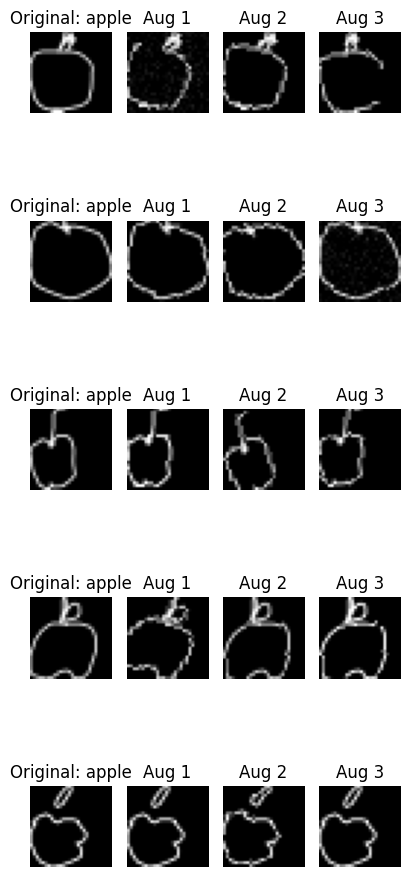

In [3]:
torch.manual_seed(123)
random.seed(123)
np.random.seed(123)
start_time = time.time()

# ---------- Dataset ----------
# Basic transformation for validation and testing
basic_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor()
])

# Advanced transformation with augmentation for training
augmentation_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    AdvancedAugmentation(prob=0.7)
])

data_dir = "data/train"
# Use augmented transformations for training
dataset = datasets.ImageFolder(root=data_dir, transform=augmentation_transform)

class_names = dataset.classes
num_classes = len(class_names)

# ---------- Validació ----------
val_dir = "data/validation"
# Use basic transform without augmentation for validation
val_dataset = datasets.ImageFolder(root=val_dir, transform=basic_transform)

# Visualize some augmented samples
visualize_augmentations(datasets.ImageFolder(root=data_dir, transform=basic_transform))

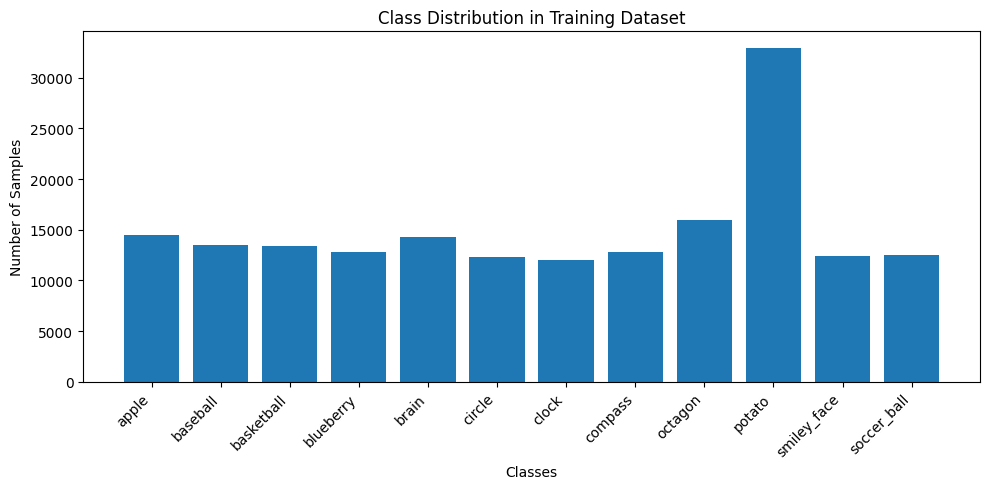

Class distribution:
apple: 14472 images
baseball: 13537 images
basketball: 13379 images
blueberry: 12787 images
brain: 14303 images
circle: 12287 images
clock: 12053 images
compass: 12760 images
octagon: 15947 images
potato: 32920 images
smiley_face: 12438 images
soccer_ball: 12534 images
Class balancing applied with WeightedRandomSampler
Class balancing applied with WeightedRandomSampler


In [4]:
# Analyze class distribution
class_counts = [0] * num_classes
for _, label in dataset:
    class_counts[label] += 1

# Display class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_names, class_counts)
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Class distribution:")
for i, name in enumerate(class_names):
    print(f"{name}: {class_counts[i]} images")

# Calculate weights for each sample to balance classes
class_weights = [1.0 / count for count in class_counts]
sample_weights = [class_weights[label] for _, label in dataset]

# Create a weighted sampler
sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

print("Class balancing applied with WeightedRandomSampler")

In [5]:
lr = 0.001
batch_size = 64

max_total_time = 600

num_core = multiprocessing.cpu_count()

# Use the weighted sampler for balanced training
dataloader = DataLoader(dataset, 
                        batch_size=batch_size,
                        sampler=sampler,  # Use weighted sampler instead of shuffle=True
                        num_workers=num_core-1,
                        persistent_workers=True,
                        prefetch_factor=4)
val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=num_core-1,
                        persistent_workers=True,
                        prefetch_factor=4)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNNModel(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.25, fc_dropout=0.5):
        super(ImprovedCNNModel, self).__init__()
        
        # First convolutional block: 2x Conv2D + MaxPool + Dropout
        self.conv1_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(32)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(dropout_rate)
        
        # Second convolutional block: 2x Conv2D + MaxPool + Dropout
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        
        # Third convolutional block: Conv2D + Global Average Pooling
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Fully connected layer
        self.fc1 = nn.Linear(128, 512)
        self.bn_fc = nn.BatchNorm1d(512)
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # First block
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second block
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third block
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.global_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.fc_dropout(x)
        x = self.fc2(x)
        
        return x

# Original model (for reference)
class ElVostreModel(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super(ElVostreModel, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling and dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.dropout2d = nn.Dropout2d(0.2)
        
        # Adaptive pooling for flexibility
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # First conv block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout2d(x)
        
        # Second conv block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2d(x)
        
        # Third conv block
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.adaptive_pool(x)
        
        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x
'''
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class AdvancedCNNModel(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super(AdvancedCNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.layer1 = ResidualBlock(32, 64, stride=2)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x
'''

'\nclass ResidualBlock(nn.Module):\n    def __init__(self, in_channels, out_channels, stride=1):\n        super(ResidualBlock, self).__init__()\n        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)\n        self.bn1 = nn.BatchNorm2d(out_channels)\n        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)\n        self.bn2 = nn.BatchNorm2d(out_channels)\n\n        self.shortcut = nn.Sequential()\n        if stride != 1 or in_channels != out_channels:\n            self.shortcut = nn.Sequential(\n                nn.Conv2d(in_channels, out_channels, 1, stride),\n                nn.BatchNorm2d(out_channels)\n            )\n\n    def forward(self, x):\n        out = F.relu(self.bn1(self.conv1(x)))\n        out = self.bn2(self.conv2(out))\n        out += self.shortcut(x)\n        out = F.relu(out)\n        return out\n\nclass AdvancedCNNModel(nn.Module):\n    def __init__(self, num_classes, dropout_rate=0.3):\n        super(AdvancedCNNModel, self).__init__()\n\n  

In [7]:
device = torch.device("cpu")
# Use the improved model based on the recommended structure
model = ImprovedCNNModel(num_classes).to(device)

In [8]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [9]:
def evaluate(model, loader, name):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    print(f"{name} Accuracy: {accuracy * 100:.2f}%")
    return accuracy

In [ ]:
epoch = 0

best_val_acc = 0.0
model_save_path = "best_model.pth"

# Initialize per-class accuracy tracking
class_correct = [0] * num_classes
class_total = [0] * num_classes

print(f"Preprocess completat. Iniciant l'entrenament del model amb {num_classes} classes.")
print("Les classes han estat balancejades per l'entrenament utilitzant WeightedRandomSampler")

while True:
    start_epoch = time.time()
    epoch += 1
    model.train()
    loop = tqdm(dataloader, desc=f"Època {epoch}", leave=False)
    
    # Reset per-epoch class statistics
    epoch_class_samples = [0] * num_classes

    for i, (images, labels) in enumerate(loop):
        if time.time() - start_time > max_total_time:
            print("Temps màxim assolit. Fi de l'entrenament")
            break
    
        # Track samples per class in this batch
        for label in labels:
            epoch_class_samples[label.item()] += 1

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
    
    if time.time() - start_time > max_total_time:
        break
        
    # Show class distribution for this epoch (verify balancing)
    if epoch % 5 == 0:  # Only show every 5 epochs to avoid clutter
        print("Class distribution in this epoch:")
        for i, name in enumerate(class_names):
            print(f"{name}: {epoch_class_samples[i]} samples")
            
    # Validació per època
    val_acc = evaluate(model, val_loader, f"Validació (després de la època {epoch}[{time.time() - start_epoch:.2f}s])")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_save_path)
        print(f"Nou millor model guardat amb {best_val_acc * 100:.2f}% de precisió de validació")

Preprocess completat. Iniciant l'entrenament del model amb 12 classes.
Les classes han estat balancejades per l'entrenament utilitzant WeightedRandomSampler


Època 1:   0%|          | 0/2804 [00:00<?, ?it/s]

# Final Avaluacio

In [ ]:
def load_best_model(path, num_classes):
    """Carga el mejor modelo guardado."""
    # Update to use the improved model
    model = ImprovedCNNModel(num_classes)
    model.load_state_dict(torch.load(path))
    model = model.to(device)
    return model

In [ ]:
best_model = load_best_model(model_save_path, num_classes)
# Evaluar el modelo en el conjunto de entrenamiento y validación
train_acc = evaluate(best_model,dataloader, "Train (subset)")
val_acc = evaluate(best_model, val_loader, "Validation (final)")

print(f"\nFinal Metrics:")
print(f"   Train Accuracy: {train_acc * 100:.2f}%")
print(f"   Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Temps total d'entrenament: {time.time() - start_time:.2f} segons")

Train (subset) Accuracy: 85.81%
Validation (final) Accuracy: 70.29%

Final Metrics:
   Train Accuracy: 85.81%
   Validation Accuracy: 70.29%
Temps total d'entrenament: 1846.96 segons


## Model Architecture Analysis

The model architecture implemented follows the recommended structure:

1. First convolutional block:
   - Two Conv2D layers with 32 filters (3x3) + BatchNorm + ReLU
   - MaxPool2D(2x2) + Dropout(0.25)

2. Second convolutional block:
   - Two Conv2D layers with 64 filters (3x3) + BatchNorm + ReLU
   - MaxPool2D(2x2) + Dropout(0.25)

3. Third convolutional block:
   - One Conv2D layer with 128 filters (3x3) + BatchNorm + ReLU
   - GlobalAveragePooling2D

4. Fully connected layers:
   - Dense(512) + BatchNorm + ReLU + Dropout(0.5)
   - Dense(num_classes)

This architecture is effective for our drawing classification task because:
1. Multiple convolutional layers extract hierarchical features
2. Batch normalization improves training stability and speed
3. Dropout layers reduce overfitting
4. Global average pooling reduces parameters and helps with spatial invariance
5. The final dense layers learn high-level representations

'# Instalar scikit-learn si no está disponible\nimport sys\nimport subprocess\n\ndef install_package(package):\n    print(f"Instalando {package}...")\n    subprocess.check_call([sys.executable, "-m", "pip", "install", package])\n    print(f"{package} instalado correctamente")\n\ntry:\n    # Intentar importar sklearn\n    import sklearn\n    print(f"scikit-learn ya está instalado (versión {sklearn.__version__})")\nexcept ImportError:\n    # Si falla, instalarlo\n    install_package("scikit-learn")\n    print("Por favor, reinicia el kernel después de la instalación para usar sklearn")'